# **Configurazioni**

In [ ]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
import sys
import time
sys.path.append('/content/pykan/kan')
sys.path.append('/content/pykan/kan/KAN.py')
from kan import *
import torch
import numpy as np
import sympy as sp
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# **Dataset**

In [ ]:
#Lettura del dataset
file_path = 'https://raw.githubusercontent.com/LucaA0111/Reti-Kolmogorov-Arnold-e-Multilayer-Perceptron-Un-Confronto-Sperimentale/refs/heads/main/Power%20Consuption/powerConsuption.csv'

df = pd.read_csv(file_path)

df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [ ]:
# Rimuovo colonne che non mi servono per la zona 1

df = df.drop(['Datetime','PowerConsumption_Zone1','PowerConsumption_Zone2'], axis = 1)

df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone3
0,6.559,73.8,0.083,0.051,0.119,20240.96386
1,6.414,74.5,0.083,0.070,0.085,20131.08434
2,6.313,74.5,0.080,0.062,0.100,19668.43373
3,6.121,75.0,0.083,0.091,0.096,18899.27711
4,5.921,75.7,0.081,0.048,0.085,18442.40964
...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,14780.31212
52412,6.947,72.6,0.082,0.051,0.093,14428.81152
52413,6.900,72.8,0.086,0.084,0.074,13806.48259
52414,6.758,73.0,0.080,0.066,0.089,13512.60504


In [ ]:
#Rimozione eventuali outilers

# Calcolo dei quartili e dell'IQR
Q1 = df['PowerConsumption_Zone3'].quantile(0.25)
Q3 = df['PowerConsumption_Zone3'].quantile(0.75)
IQR = Q3 - Q1

# Definizione dei limiti
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Rimozione degli outlier
df = df[(df['PowerConsumption_Zone3'] >= lower_bound) & (df['PowerConsumption_Zone3'] <= upper_bound)]

df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone3
0,6.559,73.8,0.083,0.051,0.119,20240.96386
1,6.414,74.5,0.083,0.070,0.085,20131.08434
2,6.313,74.5,0.080,0.062,0.100,19668.43373
3,6.121,75.0,0.083,0.091,0.096,18899.27711
4,5.921,75.7,0.081,0.048,0.085,18442.40964
...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,14780.31212
52412,6.947,72.6,0.082,0.051,0.093,14428.81152
52413,6.900,72.8,0.086,0.084,0.074,13806.48259
52414,6.758,73.0,0.080,0.066,0.089,13512.60504


In [ ]:
#Divido il datatset
X = df.drop(columns=['PowerConsumption_Zone3'], axis=1)  # Rimuovi la colonna delle etichette
y = df['PowerConsumption_Zone3']  # Seleziona solo la colonna delle etichette

# 20% del datatset riservato per i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Standardizzazione dei dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Rete KAN**

In [ ]:
#Conversione in tensori Pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

dataset = {
    'train_input': X_train,
    'train_label': y_train,
    'test_input': X_test,
    'test_label': y_test
}

In [ ]:
#Inizializzazione del modello
KAN_model = KAN(width=[X.shape[1],20,15,10,1], grid=15, k=3, seed = 42)

KAN_model

checkpoint directory created: ./model
saving model version 0.0


MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)

In [ ]:
#Alleno il modello

def train_acc():
    return torch.mean((torch.argmax(KAN_model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype=torch.float32))

def test_acc():
    return torch.mean((torch.argmax(KAN_model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype=torch.float32))


KAN_start_time1 = time.time()

KAN_results = KAN_model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc),loss_fn=torch.nn.MSELoss())

KAN_end_time1 = time.time()
KAN_training1_time = KAN_end_time1 - KAN_start_time1

| train_loss: 3.72e+03 | test_loss: 3.93e+03 | reg: 5.08e+02 | : 100%|█| 20/20 [14:03<00:00, 42.18s/

saving model version 0.1


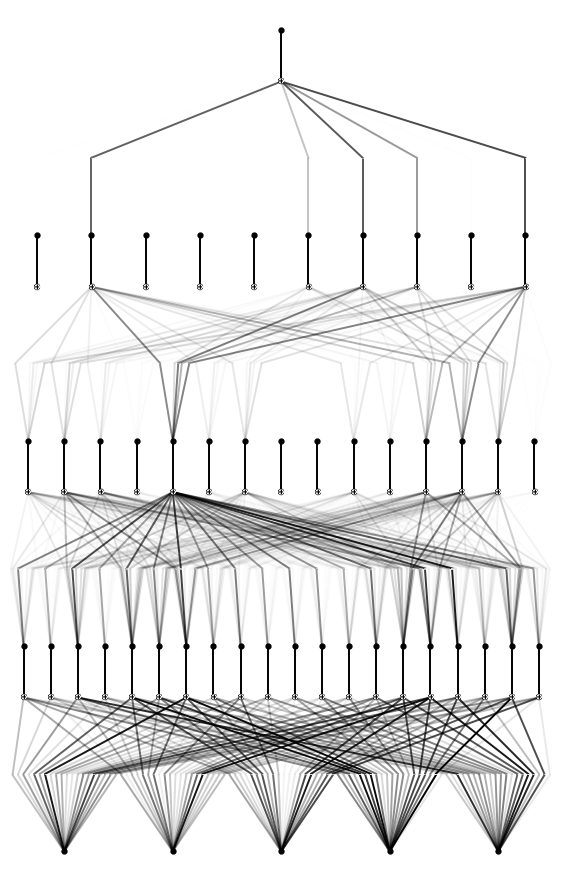

In [ ]:
#Visualizzare lo stato inziale della rete KAN
KAN_model(dataset['train_input'])
KAN_model.plot(scale = 0.7)

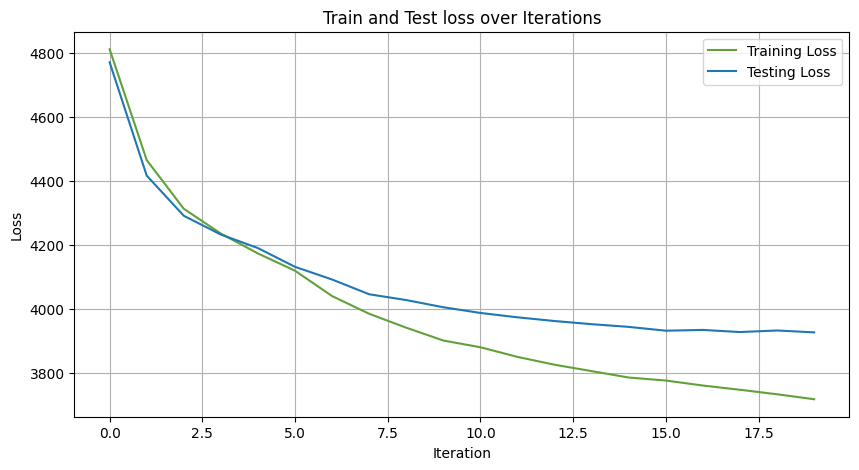

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(KAN_results["train_loss"], label='Training Loss', color='#61a13a')
plt.plot(KAN_results["test_loss"], label='Testing Loss')
plt.title('Train and Test loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

saving model version 0.2


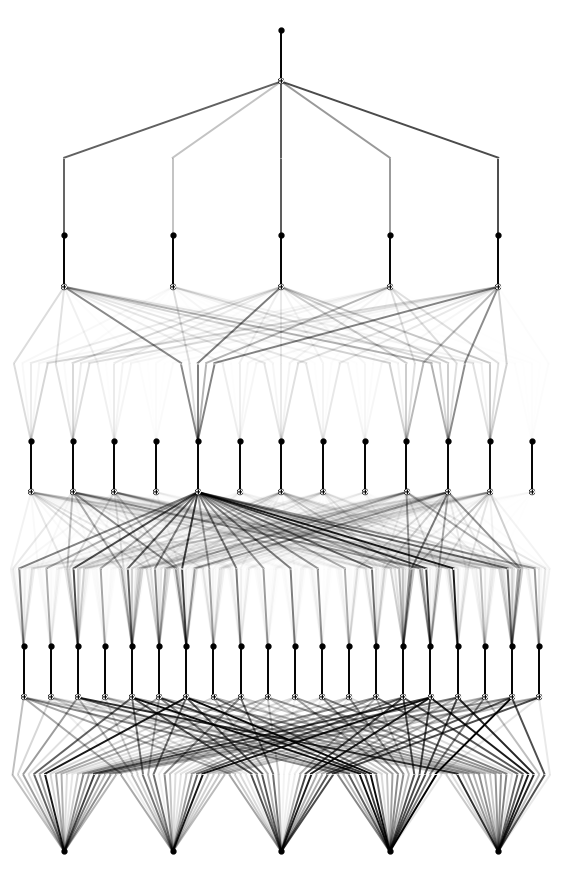

In [ ]:
KAN_model = KAN_model.prune_node()
KAN_model.plot(scale = 0.7)

In [ ]:
KAN_start_time2 = time.time()

KAN_new_results = KAN_model.fit(dataset, opt="LBFGS", steps=20,metrics=(train_acc, test_acc),loss_fn=torch.nn.MSELoss());

KAN_end_time2 = time.time()
KAN_training2_time = KAN_end_time2 - KAN_start_time2

| train_loss: 3.55e+03 | test_loss: 3.96e+03 | reg: 4.81e+02 | : 100%|█| 20/20 [15:50<00:00, 47.55s/

saving model version 0.3


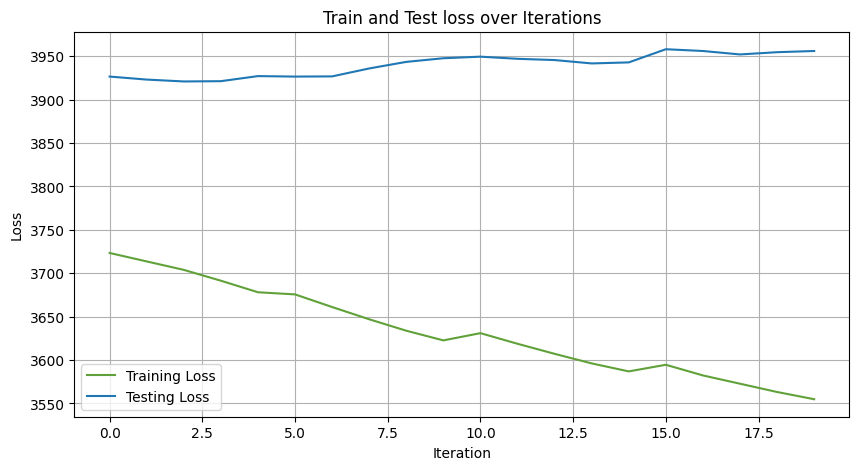

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(KAN_new_results["train_loss"], label='Training Loss', color='#61a13a')
plt.plot(KAN_new_results["test_loss"], label='Testing Loss')
plt.title('Train and Test loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
KAN_predictions = KAN_model.forward(dataset['test_input']).detach()

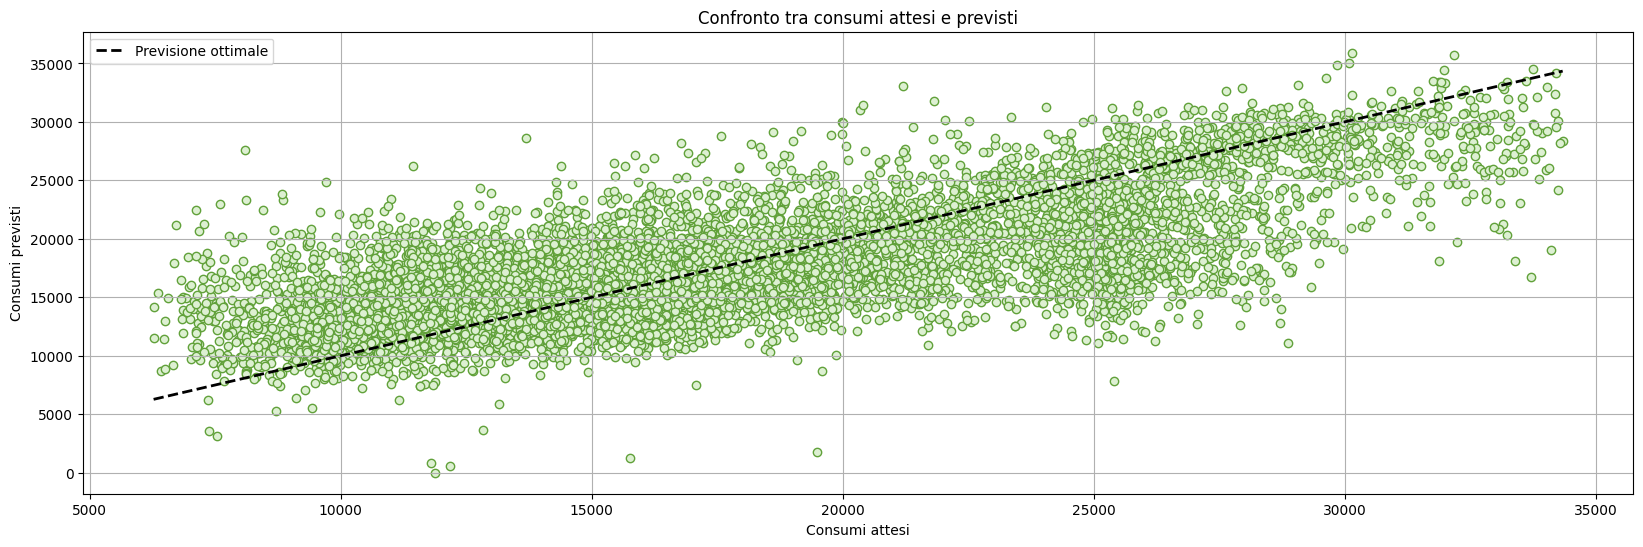

In [ ]:
# Grafico Valori attesi vs valori previsti
plt.figure(figsize=(20, 6))
plt.scatter(y_test, KAN_predictions, color="#ddf0d2",edgecolors='#61a13a', alpha = 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Previsione ottimale',  linewidth=2)
plt.xlabel('Consumi attesi')
plt.ylabel('Consumi previsti')
plt.legend()
plt.title('Confronto tra consumi attesi e previsti')
plt.grid()
plt.show()

In [ ]:
#Valuto il modello

KAN_r2 = r2_score(y_test, KAN_predictions.numpy())
KAN_mae = mean_absolute_error(y_test, KAN_predictions.numpy())
KAN_mse = mean_squared_error(y_test, KAN_predictions.numpy())
KAN_time = (KAN_training1_time + KAN_training2_time)/60

print("R²: ", KAN_r2 )

print("Errore assoluto medio: ", KAN_mae)

print("Errore quadratico medio: ", KAN_mse)

print("Tempo di addestramento (min): ",KAN_time )

R²:  0.5389585494995117
Errore assoluto medio:  2955.066
Errore quadratico medio:  15650091.0
Tempo di addestramento (min):  29.909229417641956


## **Formula simbolica**

In [38]:
#Imposto le funzioni di attivazione simboliche
lib = ['x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
KAN_model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.7859485745429993, c=2
fixing (0,0,1) with sin, r2=0.9190543293952942, c=2
fixing (0,0,2) with exp, r2=0.4427522122859955, c=2
fixing (0,0,3) with sin, r2=0.35185855627059937, c=2
fixing (0,0,4) with x^2, r2=0.7487272024154663, c=2
fixing (0,0,5) with sin, r2=0.5258321166038513, c=2
fixing (0,0,6) with sin, r2=0.8648003935813904, c=2
fixing (0,0,7) with sqrt, r2=0.8666849732398987, c=2
fixing (0,0,8) with exp, r2=0.7370061874389648, c=2
fixing (0,0,9) with sin, r2=0.7122046947479248, c=2
fixing (0,0,10) with sin, r2=0.6524303555488586, c=2
fixing (0,0,11) with sin, r2=0.5059117078781128, c=2
fixing (0,0,12) with sin, r2=0.7152101397514343, c=2
fixing (0,0,13) with log, r2=0.9157337546348572, c=2
fixing (0,0,14) with sin, r2=0.3670278489589691, c=2
fixing (0,0,15) with sin, r2=0.8456174731254578, c=2
fixing (0,0,16) with sin, r2=0.7836388945579529, c=2
fixing (0,0,17) with exp, r2=0.6624280214309692, c=2
fixing (0,0,18) with sin, r2=0.6690827012062073, c=2
f

In [39]:
formula = sp.sympify(str(KAN_model.symbolic_formula()[0][0]))
formula

86474.4982813532*exp(1.02762901030087e-90*(0.12712121706697*(-0.533874813828049*x_2 - 1)**2 - 0.114042462712785*log(9.41656017303467*x_4 + 6.60960006713867) - 0.0221704504538907*log(3.42711997032166*x_5 + 2.09383988380432) + 0.168954330672137*sin(1.90655982494354*x_1 - 8.97560024261475) + 0.778847568323307*sin(9.32736015319824*x_3 + 9.99503993988037) + 1)**0.133913480647212*(0.0440747012510645*exp(1.01127982139587*x_1) + 0.277112222318289*sin(1.02327990531921*x_2 - 3.98767995834351) - 0.439570635615452*sin(7.35623979568481*x_3 + 9.59119987487793) + 0.254626370064282*sin(0.683519840240479*x_4 + 4.43680000305176) + 0.150007211013966*sin(0.659439861774445*x_5 - 7.8244800567627) + 1)**0.223010628615228*(-0.0681327570368931*sin(8.19079971313477*x_1 - 9.3864803314209) + 0.143016164291209*sin(1.30071985721588*x_2 + 9.06816005706787) + 0.114009690039804*sin(7.86432027816772*x_3 + 8.58799934387207) - 0.288430354191012*sin(0.842319846153259*x_5 + 7.57096004486084) + 1 + 0.000323240936739468*exp(

# **Rete MLP**


In [ ]:
#Costruzione del modello
MLP_model = Sequential()
dropout_rate = 0.2

# Primo strato
MLP_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

#Dropout
MLP_model.add(Dropout(dropout_rate))

# Secondo strato
MLP_model.add(Dense(64, activation='relu'))

#Batch Normalization
MLP_model.add(BatchNormalization())

# Terzo strato
MLP_model.add(Dense(32, activation='relu'))

# Strato di output
MLP_model.add(Dense(1, activation='linear'))

# Displaying the model summary
MLP_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Compiling the model
MLP_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Allenamento del modello
MLP_start_time1 = time.time()

MLP_history = MLP_model.fit(X_train, y_train, epochs=300, verbose=1, batch_size = 64 ,validation_data=(X_test, y_test))

MLP_end_time1 = time.time()

MLP_training1_time = MLP_end_time1 - MLP_start_time1

Epoch 1/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 328685152.0000 - val_loss: 256692640.0000
Epoch 2/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 200185872.0000 - val_loss: 113026320.0000
Epoch 3/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 56335144.0000 - val_loss: 26957698.0000
Epoch 4/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 31087698.0000 - val_loss: 27200556.0000
Epoch 5/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 28666132.0000 - val_loss: 23374716.0000
Epoch 6/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27398008.0000 - val_loss: 23274366.0000
Epoch 7/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 26002188.0000 - val_loss: 24810240.0000
Epoch 8/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 24777002.0000 - val_loss: 21344438.0000
Epoch 9/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 23488702.0000 - val_loss: 21111510.0000
Epoch 10/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 20993228.0000 - val_loss:

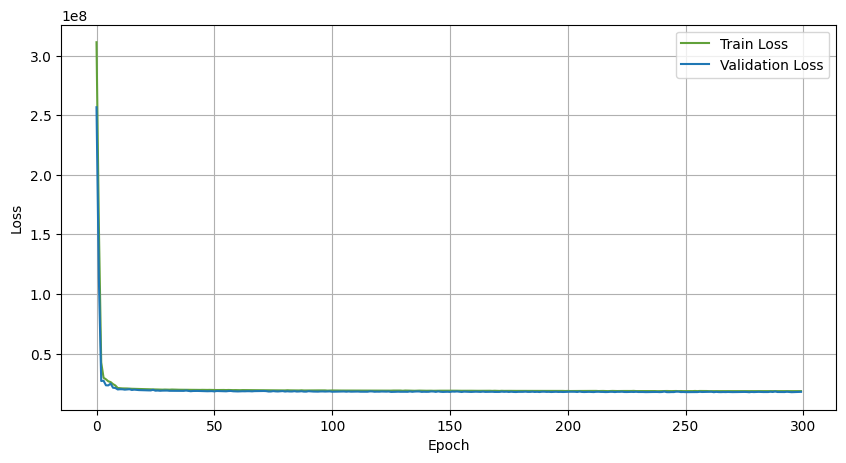

In [ ]:
#Grafico
plt.figure(figsize=(10, 5))
plt.plot(MLP_history.history['loss'], label='Train Loss', color='#61a13a')
plt.plot(MLP_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Allenamento ulteriore del modello
MLP_start_time2 = time.time()

MLP_new_history = MLP_model.fit(X_train, y_train, epochs=300, batch_size = 64, verbose=1,validation_data=(X_test, y_test))

MLP_end_time2 = time.time()

MLP_training2_time = MLP_end_time2 - MLP_start_time2

Epoch 1/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18512040.0000 - val_loss: 17707176.0000
Epoch 2/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18303450.0000 - val_loss: 17876736.0000
Epoch 3/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18318786.0000 - val_loss: 17704228.0000
Epoch 4/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18630164.0000 - val_loss: 17696840.0000
Epoch 5/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18374034.0000 - val_loss: 17468568.0000
Epoch 6/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18533024.0000 - val_loss: 17618904.0000
Epoch 7/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18369312.0000 - val_loss: 17718812.0000
Epoch 8/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18502182.0000 - val_loss: 17600344.0000
Epoch 9/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18370200.0000 - val_loss: 17625054.0000
Epoch 10/300
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18285026.0000 - val_loss: 176

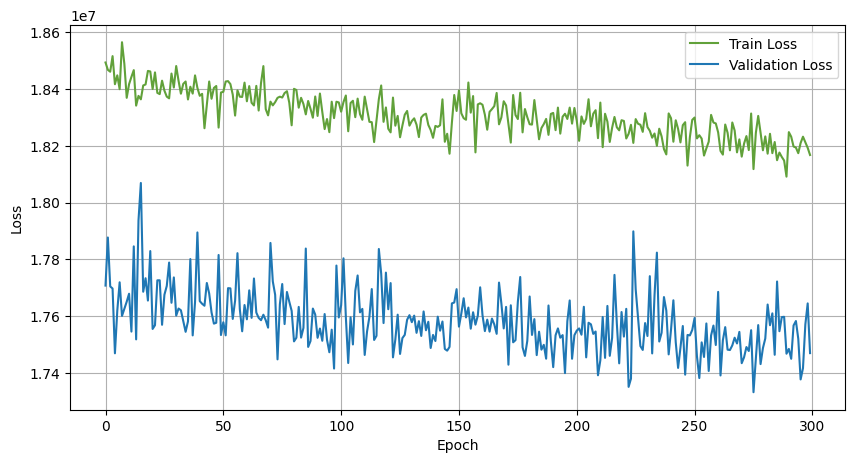

In [28]:
#Grafico
plt.figure(figsize=(10, 5))
plt.plot(MLP_new_history.history['loss'], label='Train Loss', color='#61a13a')
plt.plot(MLP_new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
#Predizione dei valori
MLP_predictions = MLP_model.predict(X_test)

321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


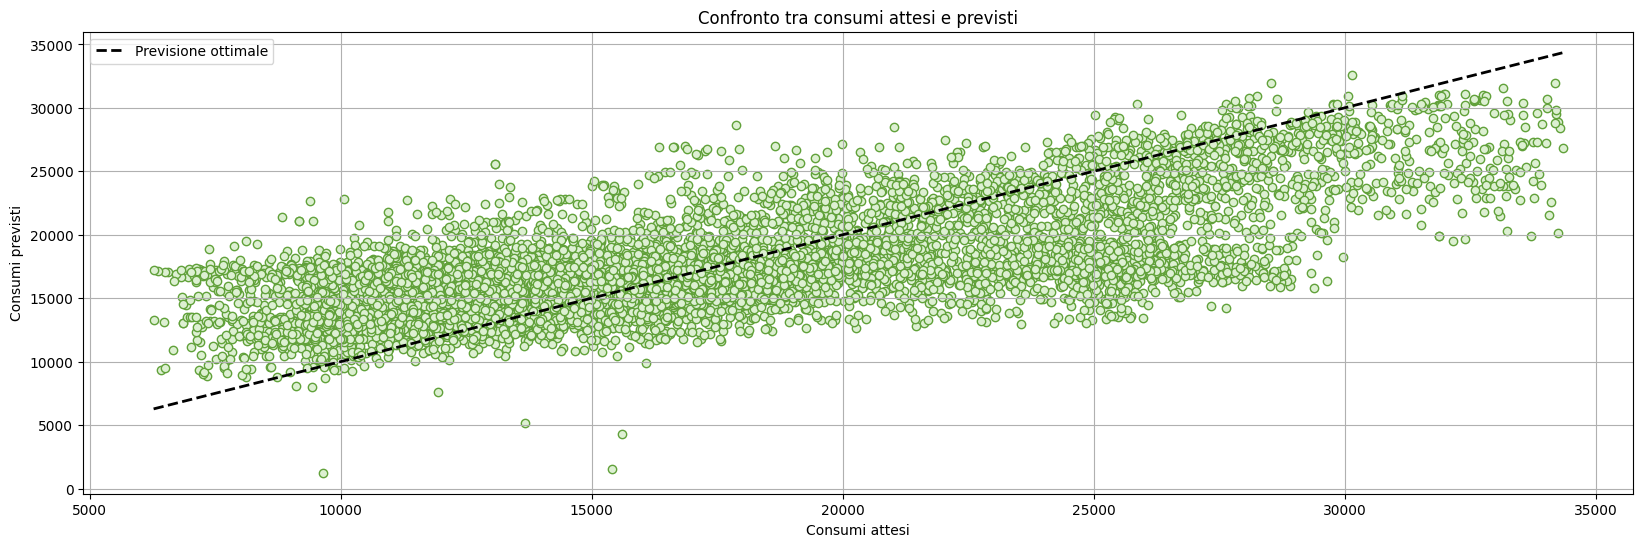

In [30]:
# Grafico Valori attesi vs valori previsti
plt.figure(figsize=(20, 6))
plt.scatter(y_test, MLP_predictions, color="#ddf0d2",edgecolors='#61a13a', alpha = 1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Previsione ottimale',  linewidth=2)
plt.xlabel('Consumi attesi')
plt.ylabel('Consumi previsti')
plt.legend()
plt.grid()
plt.title('Confronto tra consumi attesi e previsti')
plt.show()

In [31]:
#Valuto il modello
MLP_r2 = r2_score(y_test, MLP_predictions)
MLP_mae = mean_absolute_error(y_test, MLP_predictions)
MLP_mse = mean_squared_error(y_test, MLP_predictions)
MLP_time = (MLP_training1_time + MLP_training2_time)/60

print("R²: ", MLP_r2 )

print("Errore assoluto medio: ", MLP_mae)

print("Errore quadratico medio: ", MLP_mse)

print("Tempo di addestramento (min): ",MLP_time )

R²:  0.485368549823761
Errore assoluto medio:  3196.9377
Errore quadratico medio:  17469208.0
Tempo di addestramento (min):  17.341321702798208


# **KAN vs MLP**

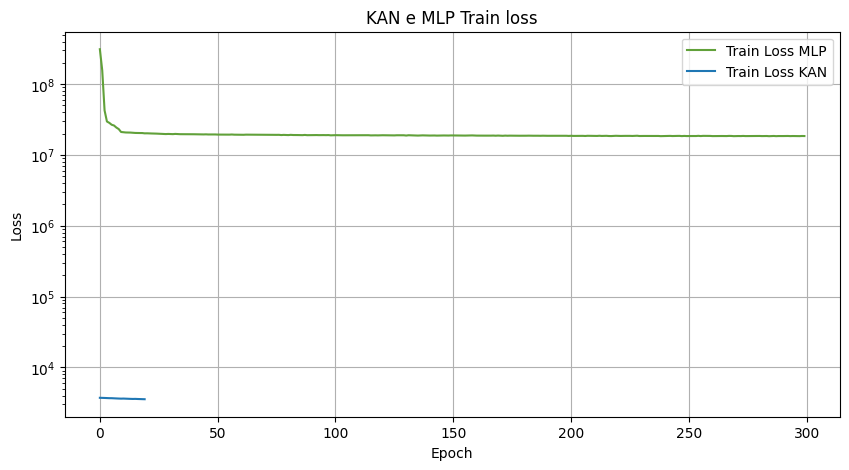

In [32]:
#Confronto train loss
plt.figure(figsize=(10, 5))
plt.plot(MLP_history.history['loss'], label='Train Loss MLP', color='#61a13a')
plt.plot(KAN_new_results["train_loss"], label='Train Loss KAN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.title('KAN e MLP Train loss')
plt.show()

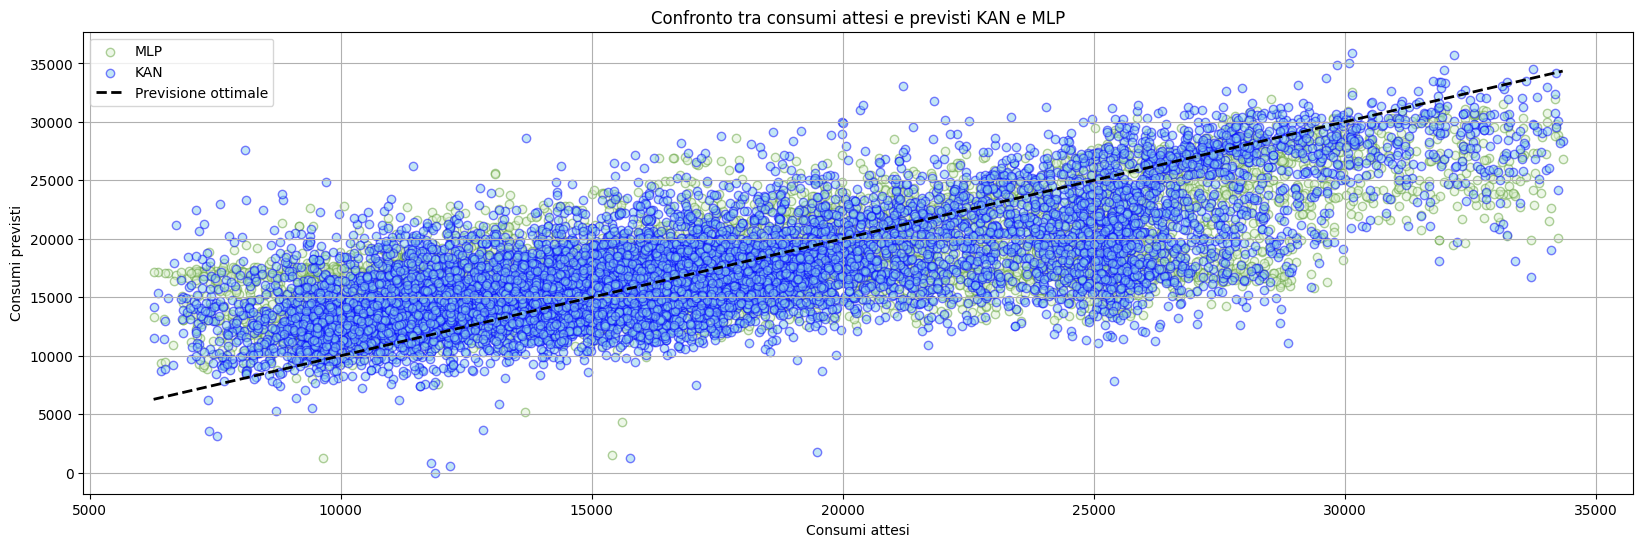

In [33]:
# Grafico Valori attesi vs valori previsti
plt.figure(figsize=(20, 6))
plt.scatter(y_test, MLP_predictions, color="#ddf0d2",edgecolors='#61a13a', alpha = 0.5, label='MLP')
plt.scatter(y_test, KAN_predictions, color ="skyblue",edgecolors='blue', alpha = 0.5, label='KAN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Previsione ottimale',  linewidth=2)
plt.xlabel('Consumi attesi')
plt.ylabel('Consumi previsti')
plt.legend()
plt.grid()
plt.title('Confronto tra consumi attesi e previsti KAN e MLP')
plt.show()

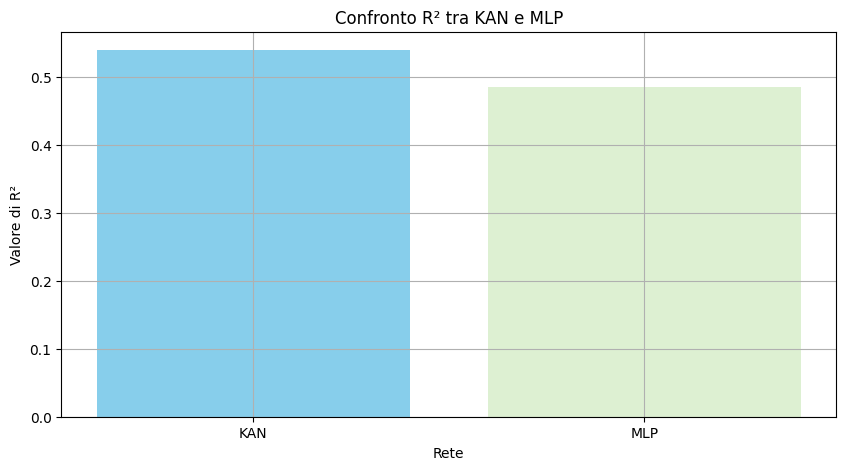

R² KAN:  0.5389585494995117
R² MLP:  0.485368549823761


In [34]:
rete = ['KAN', 'MLP']
r_2 = [KAN_r2, MLP_r2]

plt.figure(figsize=(10, 5))
plt.bar(rete, r_2, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Valore di R²')
plt.title('Confronto R² tra KAN e MLP')
plt.grid(True)
plt.show()

print("R² KAN: ", KAN_r2)
print("R² MLP: ", MLP_r2)

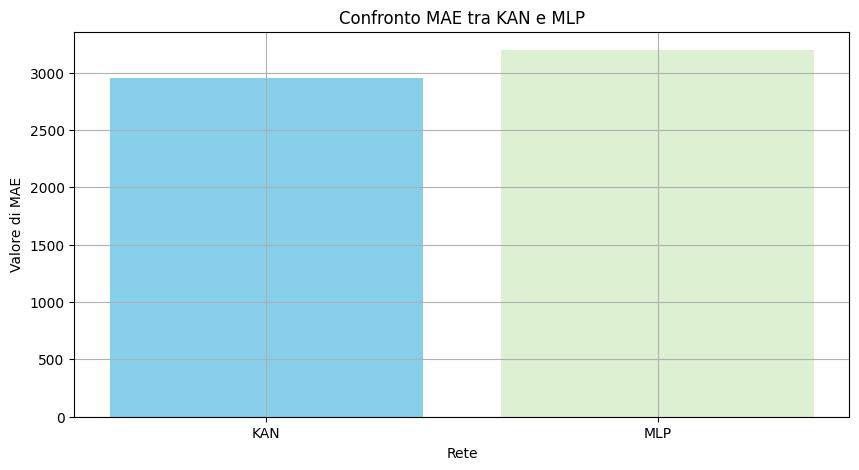

MAE KAN:  2955.066
MAE MLP:  3196.9377


In [35]:
rete = ['KAN', 'MLP']
mae = [KAN_mae, MLP_mae]

plt.figure(figsize=(10, 5))
plt.bar(rete, mae, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Valore di MAE')
plt.title('Confronto MAE tra KAN e MLP')
plt.grid()
plt.show()

print("MAE KAN: ", KAN_mae)
print("MAE MLP: ", MLP_mae)

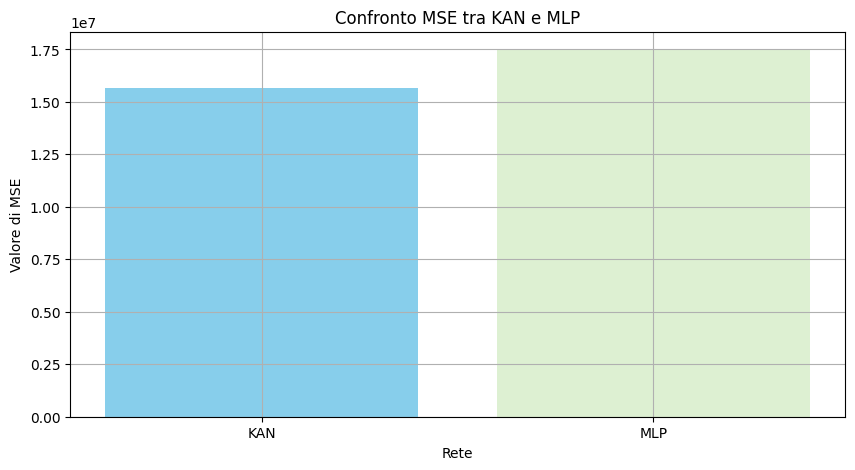

MSE KAN:  15650091.0
MSE MLP:  17469208.0


In [36]:
rete = ['KAN', 'MLP']
mse = [KAN_mse, MLP_mse]

plt.figure(figsize=(10, 5))
plt.bar(rete, mse, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Valore di MSE')
plt.title('Confronto MSE tra KAN e MLP')
plt.grid()
plt.show()

print("MSE KAN: ", KAN_mse)
print("MSE MLP: ", MLP_mse)

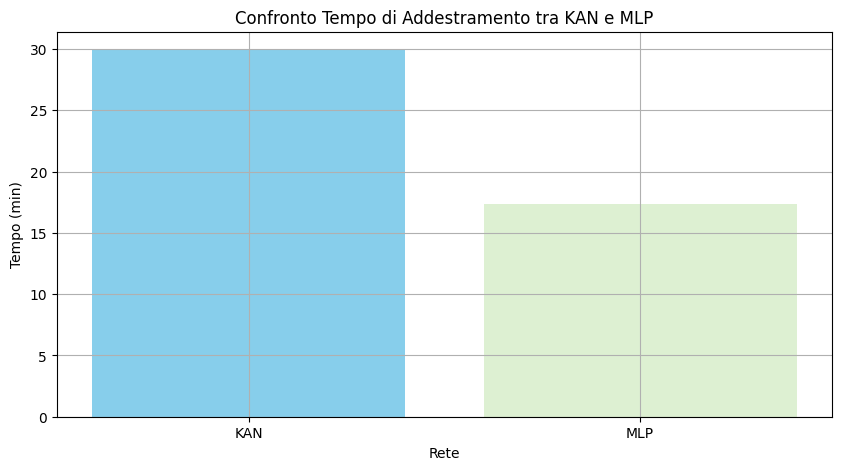

Tempo KAN:  29.909229417641956
Tempo MLP:  17.341321702798208


In [37]:
rete = ['KAN', 'MLP']
mse = [KAN_time, MLP_time]

plt.figure(figsize=(10, 5))
plt.bar(rete, mse, color=["skyblue", "#ddf0d2"])
plt.xlabel('Rete')
plt.ylabel('Tempo (min)')
plt.title('Confronto Tempo di Addestramento tra KAN e MLP')
plt.grid()
plt.show()

print("Tempo KAN: ", KAN_time)
print("Tempo MLP: ", MLP_time)